In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions.functions import EmissionProfile, AbsoluteMetricsPulseDefaultCO2, AbsoluteMetrics, RelativeMetrics
from climate_models.fair_emulator import BackgroundSpeciesQuantities, FaIRClimateModel, GWPStarEquivalentEmissionsFunction, GWPStarClimateModel, LWEClimateModel

C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parameters

In [2]:
studied_species = "Aviation NOx ST O3 increase"
co2_method = 'IPCC' # IPCC or FaIR
start_year = 2000 # 1765 for FaIR
t0 = 2020
time_horizon = 20
end_year = t0 + time_horizon
unit_value = 1
unit_value_co2 = 1
tcre = 0.00045

# Default values recommended for unit value
## CO2: 1e10 kg, i.e. 10 Mt
## Contrails: 1 km
## NOx:
## H2O: 1e10 kg, i.e. 10 Mt
## Soot:
## Sulfur:

In [3]:
if studied_species == "Aviation CO2":
    sensitivity_erf = 0 # Not used
    ratio_erf_rf = 1
    efficacy_rf = 1
    efficacy_erf = 1
elif studied_species == "Aviation contrails":
    sensitivity_erf = 9.36e-13
    ratio_erf_rf = 0.42 #0.55 # 0.42
    efficacy_rf = 0.208
    efficacy_erf = 0.38
elif studied_species == "Aviation NOx ST O3 increase":
    sensitivity_erf = 34.4e-12 * (14/46)
    ratio_erf_rf = 1.37
    efficacy_rf = 1
    efficacy_erf = 1
elif studied_species == "Aviation NOx CH4 decrease and induced":
    unit_value = 1
    sensitivity_erf = -0.82e-9
    ratio_erf_rf = 1.18
    efficacy_rf = 1
    efficacy_erf = 1
elif studied_species == "Aviation H2O":
    sensitivity_erf = 0.0052e-12
    ratio_erf_rf = 1
    efficacy_rf = 1
    efficacy_erf = 1
elif studied_species == "Aviation soot":
    sensitivity_erf = 100.7e-12 # Not used
    ratio_erf_rf = 1
    efficacy_rf = 1
    efficacy_erf = 1
elif studied_species == "Aviation sulfur":
    sensitivity_erf = -19.9e-12 # Not used
    ratio_erf_rf = 1
    efficacy_rf = 1
    efficacy_erf = 1
    
sensitivity_erf_co2 = 0 # Not used
ratio_erf_rf_co2 = 1
unit_value_co2 = 1*10**10

## Metrics calculation

In [4]:
background_species_quantities = BackgroundSpeciesQuantities(start_year, end_year, rcp='RCP45')
emission_profile = EmissionProfile(start_year,t0,time_horizon, 'pulse', unit_value)
emission_profile_co2 = EmissionProfile(start_year,t0,time_horizon, 'pulse', unit_value_co2)

In [5]:
radiative_forcing, effective_radiative_forcing, temperature = LWEClimateModel(start_year, end_year, emission_profile, studied_species, sensitivity_erf, ratio_erf_rf, tcre)
radiative_forcing_unit, effective_radiative_forcing_unit, temperature_unit = radiative_forcing/unit_value, effective_radiative_forcing/unit_value, temperature/unit_value

In [6]:
if co2_method == 'IPCC':
    radiative_forcing_co2, effective_radiative_forcing_co2, agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, temperature_co2, agtp_co2, iagtp_co2, atr_co2 = AbsoluteMetricsPulseDefaultCO2(time_horizon, unit_value_co2)
    radiative_forcing_co2, effective_radiative_forcing_co2, agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, temperature_co2, agtp_co2, iagtp_co2, atr_co2 = radiative_forcing_co2/unit_value_co2, effective_radiative_forcing_co2/unit_value_co2, agwp_rf_co2/unit_value_co2, agwp_erf_co2/unit_value_co2, aegwp_rf_co2/unit_value_co2, aegwp_erf_co2/unit_value_co2, temperature_co2/unit_value_co2, agtp_co2/unit_value_co2, iagtp_co2/unit_value_co2, atr_co2/unit_value_co2
elif co2_method == 'FaIR':
    radiative_forcing_co2, effective_radiative_forcing_co2, temperature_co2 = FaIRClimateModel(start_year, end_year, background_species_quantities, emission_profile, "Aviation CO2", sensitivity_erf_co2, ratio_erf_rf_co2)
    radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, temperature_co2_unit = radiative_forcing_co2/unit_value_co2, effective_radiative_forcing_co2/unit_value_co2, temperature_co2/unit_value_co2
    agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = AbsoluteMetrics(radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, 1, 1, temperature_co2_unit, time_horizon)
agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr = AbsoluteMetrics(radiative_forcing_unit, effective_radiative_forcing_unit, efficacy_rf, efficacy_erf, temperature_unit, time_horizon)
gwp_rf, gwp_erf, egwp_rf, egwp_erf, gtp, igtp, ratr = RelativeMetrics(agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2, agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr)

In [7]:
index_noms = ["GWP_RF", "GWP_ERF", "E-GWP_RF", "E-GWP_ERF", "GTP", "iGTP", "r-ATR"]
df = pd.DataFrame([gwp_rf, gwp_erf, egwp_rf, egwp_erf, gtp, igtp, ratr], columns=["Value"], index=index_noms)
df

,Value
GWP_RF,305.552982
GWP_ERF,418.607586
E-GWP_RF,305.552982
E-GWP_ERF,418.607586
GTP,55.629848
iGTP,397.954587
r-ATR,397.954587


In [8]:
studied_species = "Aviation NOx CH4 decrease and induced"

if studied_species == "Aviation CO2":
    sensitivity_erf = 0 # Not used
    ratio_erf_rf = 1
    efficacy_rf = 1
    efficacy_erf = 1
elif studied_species == "Aviation contrails":
    sensitivity_erf = 9.36e-13
    ratio_erf_rf = 0.42 #0.55 # 0.42
    efficacy_rf = 0.208
    efficacy_erf = 0.38
elif studied_species == "Aviation NOx ST O3 increase":
    sensitivity_erf = 34.4e-12 * (14/46)
    ratio_erf_rf = 1.37
    efficacy_rf = 1
    efficacy_erf = 1
elif studied_species == "Aviation NOx CH4 decrease and induced":
    unit_value = 1
    sensitivity_erf = -0.82e-9
    ratio_erf_rf = 1.18
    efficacy_rf = 1
    efficacy_erf = 1
elif studied_species == "Aviation H2O":
    sensitivity_erf = 0.0052e-12
    ratio_erf_rf = 1
    efficacy_rf = 1
    efficacy_erf = 1
elif studied_species == "Aviation soot":
    sensitivity_erf = 100.7e-12 # Not used
    ratio_erf_rf = 1
    efficacy_rf = 1
    efficacy_erf = 1
elif studied_species == "Aviation sulfur":
    sensitivity_erf = -19.9e-12 # Not used
    ratio_erf_rf = 1
    efficacy_rf = 1
    efficacy_erf = 1
    
emission_profile_ch4 = EmissionProfile(start_year,t0,time_horizon, 'pulse', unit_value)
radiative_forcing_ch4, effective_radiative_forcing_ch4, temperature_ch4 = LWEClimateModel(start_year, end_year, emission_profile_ch4, studied_species, sensitivity_erf, ratio_erf_rf, tcre)
radiative_forcing_unit_ch4, effective_radiative_forcing_unit_ch4, temperature_unit_ch4 = radiative_forcing_ch4/unit_value, effective_radiative_forcing_ch4/unit_value, temperature_ch4/unit_value
agwp_rf_ch4, agwp_erf_ch4, aegwp_rf_ch4, aegwp_erf_ch4, agtp_ch4, iagtp_ch4, atr_ch4 = AbsoluteMetrics(radiative_forcing_unit_ch4, effective_radiative_forcing_unit_ch4, efficacy_rf, efficacy_erf, temperature_unit_ch4, time_horizon)
gwp_rf_ch4, gwp_erf_ch4, egwp_rf_ch4, egwp_erf_ch4, gtp_ch4, igtp_ch4, ratr_ch4 = RelativeMetrics(agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2, agwp_rf_ch4, agwp_erf_ch4, aegwp_rf_ch4, aegwp_erf_ch4, agtp_ch4, iagtp_ch4, atr_ch4)

In [9]:
index_noms = ["GWP_RF", "GWP_ERF", "E-GWP_RF", "E-GWP_ERF", "GTP", "iGTP", "r-ATR"]
df = pd.DataFrame([gwp_rf+gwp_rf_ch4, gwp_erf+gwp_erf_ch4, egwp_rf+egwp_rf_ch4, egwp_erf+egwp_erf_ch4, gtp+gtp_ch4, igtp+igtp_ch4, ratr+ratr_ch4], columns=["Value"], index=index_noms)
df

,Value
GWP_RF,38.200833
GWP_ERF,103.132049
E-GWP_RF,38.200833
E-GWP_ERF,103.132049
GTP,-65.619133
iGTP,123.885793
r-ATR,123.885793


## Analysis (for CO2)

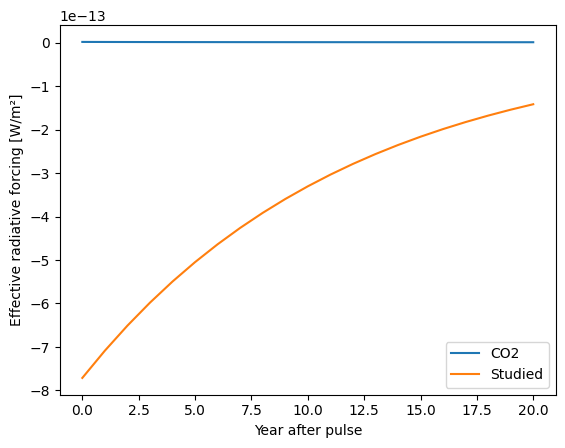

In [10]:
plt.plot(radiative_forcing_co2, label='CO2')
plt.plot(effective_radiative_forcing_unit_ch4[t0-start_year:end_year], label='Studied')
plt.xlabel('Year after pulse')
plt.ylabel('Effective radiative forcing [W/m²]')
plt.legend()

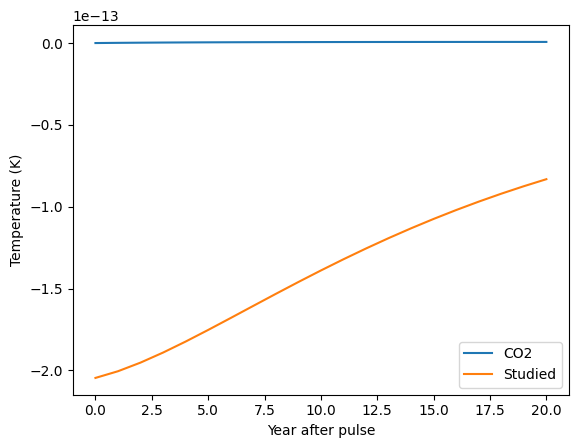

In [11]:
plt.plot(temperature_co2, label='CO2')
plt.plot(temperature_unit_ch4[t0-start_year:end_year], label='Studied')
plt.xlabel('Year after pulse')
plt.ylabel('Temperature (K)')
plt.legend()

In [12]:
temperature_unit

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.77678428e-12, 1.70155466e-13, 1.49535877e-13, 1.32080929e-13,
       1.17293357e-13, 1.04754231e-13, 9.41106081e-14, 8.50651363e-14,
       7.73672958e-14, 7.08060199e-14, 6.52034782e-14, 6.04098405e-14,
       5.62988645e-14, 5.27641799e-14, 4.97161570e-14, 4.70792697e-14,
       4.47898729e-14, 4.27943315e-14, 4.10474426e-14, 3.95111077e-14,
       3.81532134e-14])